# square root filter

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
# from numpy.random import Generator, MT19937

#sns.set_theme()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
#sns.set(font=['Hiragino sans'])

In [2]:
def RungeKutta4(initial, time, model, F):
    """
    Parameters
    ----------
    F : 
        Forcing constant, variable used in L96
    """
    dt = time[1] - time[0]
    states = [initial]
    x = initial
    for t in time[:-1]:
        k1 = model(x, F)
        x1 = x + k1 * dt/2
        k2 = model(x1, F)
        x2 = x + k2 * dt/2
        k3 = model(x2, F)
        x3 = x + k3 * dt
        k4 = model(x3, F)
        x = x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
        states.append(x)
    states = np.stack(states)
    return states

def RK4(x, dt, model, F):
    """
    Parameters
    ----------
    F : 
        Forcing constant, variable used in L96
    """
    for i in range(1):
        k1 = model(x, F)
        x1 = x + k1 * dt/2
        k2 = model(x1, F)
        x2 = x + k2 * dt/2
        k3 = model(x2, F)
        x3 = x + k3 * dt
        k4 = model(x3, F)
        x = x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
    return x

def L96(x, F):
    """
    Lorenz 96 model with constant forcing.
    Cited by "https://en.wikipedia.org/wiki/Lorenz_96_model"
    
    Parameters
    ----------
    x : 
        variables
    F :
       Forcing constant 
    N : int
        number of sites
    """
    N = 40
    # Setting up vector
    d = np.zeros(N, dtype=np.float_)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


def simulatior(time_step=0.01):
    N = 40
    F = 8.0
    ratio = 0.001
    year = 2
#     time_step = 0.01
    total_step = 0.2 * 365 * year
    time = np.arange(0.0, total_step + time_step, time_step, dtype=float)

    x = np.full(N, F, dtype=np.float_)
    x[19] += F * ratio
    dat = RungeKutta4(x, time, L96, F=F)

In [3]:
with open("RK4_GeneratedData.pkl", "rb") as f:
    origin = pickle.load(f)    
with open("NormalNoise.pkl", "rb") as f:
    noise = pickle.load(f)
    
# dat = simulatior(0.001)
# seed = 46
# rg = Generator(MT19937(seed))
# # ノイズとして加える正規分布
# noise = rg.standard_normal(dat.shape)

In [4]:
"""
一年分のstep回数は以下の計算式だから、
後半1年分をとる。
datのtims_stepは0.01刻み
"""
obs_dat = origin + noise
time_step = 0.01
total_step = int(0.2 * 365 / time_step)
origin = origin[total_step:, :]
obs_dat = obs_dat[total_step:, :]

# 0.05=6(h)ごとのデータを抽出
t = int(0.05 / time_step)
six_hour = np.arange(0, len(obs_dat), t, dtype=int)
origin = origin[six_hour, :]
obs_dat = obs_dat[six_hour, :]

In [5]:
print(obs_dat.shape)
obs_dat.dtype = np.float_

(1461, 40)


In [6]:
# 変数
N = 40
I = np.identity(N, dtype=np.float_)
H = np.identity(N, dtype=np.float_)
R = np.identity(N, dtype=np.float_)
alpha = 1.2
delta = 1e-8
dt = 0.05

In [201]:
def one_shotSRF(x_a, y_o, alpha=alpha, delta=delta, dt=dt, I=I, H=H, R=R):
    """
    KFの一回単位のシミュレーション。
    
    Parameter
    ---------
    x_a : 
    P_a :
    y_o :
    alpha :
        共分散膨張率
    delta : 
        Mの接線形近似のパラメタ
    dt : 0.05
        RK4のtime step。
    I :
    H :
    R :
    
    Return
    ------
    x_a, P_a
    """
    x_f = np.zeros((N, en))
    dX_f = np.zeros((N, en))
    x_aa = np.zeros((N, en))
    E = np.eye(en)

    for j in range(en):
        x_f[:, j] = RK4(x_a[:, j], dt, model=L96, F=8)
    #print(x_f[0, 0], x_a[0, 0])
    x_fbar = np.mean(x_f, axis=1)
    for j in range(en):
        dX_f[:, j] = x_f[:, j] - x_fbar
    dY_f = H @ dX_f

    l = np.zeros((N, N))
    a = [0.1 ,0.25, 0.5, 0.6, 1.0, 0.6, 0.5, 0.25, 0.1]
    #a = [1.0] * 9
    for j in range(N):
        for k in range(len(a)):
            l[j, (j + k - (len(a) // 2)) % N] = a[k]

    #l = np.ones((N, N))

    P_f = dX_f @ dX_f.T / (en - 1)

    #for j in range(N):
    #    for k in range(N):
    #        P_f[j, k] *= l[j, k]

    K = P_f * H.T * np.linalg.inv(H * P_f * H.T + R)
    #y_o = obs_dat[i, :]
    x_abar = x_fbar + K @ (y_o - H @ x_fbar)
    #x_a = x_f + K @ (y_o - H @ x_f)
    #x_a = x_a
    P_a = (I - K @ H) @ P_f

    A = E - dY_f.T @ np.linalg.inv(H @ P_f @ H.T + (en - 1) * R) @ dY_f
    w, v = np.linalg.eigh(A)
    D = np.zeros((en, en))
    for j in range(en):
        if w[j] < 0:
            w[j] = 0
        D[j, j] = np.sqrt(w[j])
    dX_a = dX_f @ v @ D @ v.T * ((en - 1) ** 0.5)

    for j in range(en):
        x_aa[:, j] = dX_a[:, j] + x_abar
    return x_aa, P_a

In [202]:
# 変数
N = 40
mm = 40
en = 100
I = np.identity(N, dtype=np.float_)
H = np.identity(N, dtype=np.float_)
R = np.identity(mm, dtype=np.float_)
dt = 0.05

x_f = np.random.normal(2, 3, (N, en))
x_a = x_f



# KF simulation
x_analyze = [x_a]
kk = []
for i in range(1, len(obs_dat)):
    y_o = obs_dat[i, :]
    x_a, K = one_shotSRF(x_a, y_o, mm)
    x_analyze.append(x_a)
    kk.append(K)
x_analyze = np.stack(x_analyze)
kk = np.stack(kk)


Text(0.5, 1.0, 'ある地点での解析結果(500stepまで)')

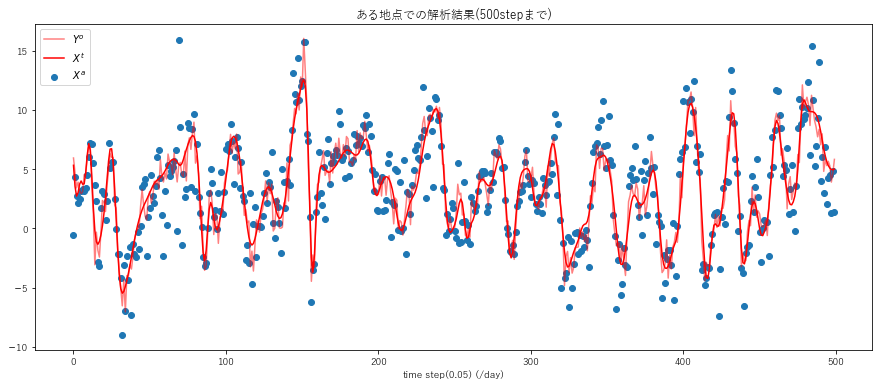

In [203]:
fig, ax = plt.subplots(figsize=(15, 6))
length = 500
t = 0
s = 0
ax.scatter(range(len(x_analyze[:length, t, s])), x_analyze[:length, t, s], label="$X^a$")
# ax.plot(x_analyze[:500, 1])
ax.plot(obs_dat[:length, t], alpha=0.5, color='r', label="$Y^o$")
ax.plot(origin[:length, t], label="$X^t$", color="red")
ax.legend()
ax.set_xlabel("time step(0.05) (/day)")
ax.set_title(f"ある地点での解析結果({length}stepまで)")

In [192]:
err = np.power(x_analyze[:,:,0] - origin, 2).sum(axis=1) / 40
print(np.average(np.sqrt(err[300:700])))

0.6420265338887767


Text(0.5, 1.0, '各time stepでの平均二乗誤差')

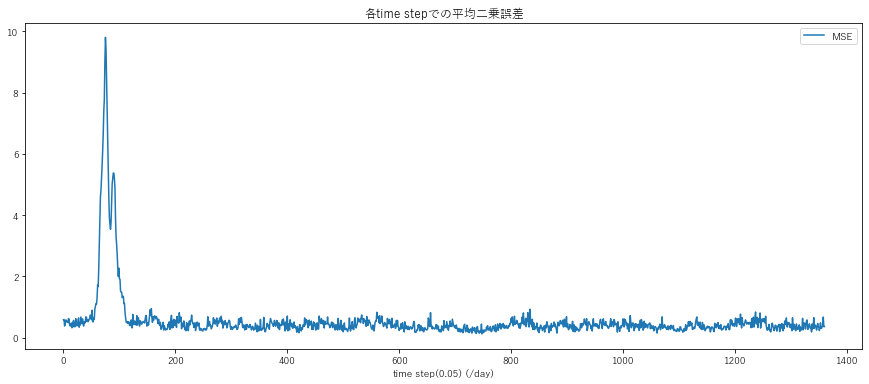

In [193]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(err[100:], label="MSE")
ax.legend()
ax.set_xlabel("time step(0.05) (/day)")
ax.set_title("各time stepでの平均二乗誤差")

In [158]:
x_analyze[-1]

array([[ 0.86733597,  1.14815451,  0.94710604, ...,  0.82108254,
         1.18901582,  0.84758059],
       [ 2.98050419,  3.34624615,  3.20836638, ...,  2.90871529,
         2.97140145,  2.84213157],
       [ 4.5816437 ,  4.48084842,  4.20210705, ...,  5.76212422,
         5.65404988,  3.34907203],
       ...,
       [ 4.57506667,  4.53734735,  4.55770589, ...,  4.49136705,
         4.74516948,  4.38962664],
       [-2.85222417, -2.9490075 , -2.93769464, ..., -2.43397135,
        -3.29201082, -2.30231584],
       [ 2.73932318,  2.64233856,  2.60136263, ...,  2.87178874,
         2.18278378,  3.2055375 ]])